In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm import trange

In [2]:
@njit
def spins(iter, Lx, Ly):
    '''
    Аргументы:
        iter (int): текущая итерация
        Lx (int): размер решетки по Ох
        Ly (int): размер решетки по Оу

    Возвращает res (np.array) - уникальный для каждой итерации массив из чисел +1 или -1 (спины) размера Lx * Ly
    '''
    res = np.zeros((Lx, Ly), dtype=np.int8)
    for i in range(Lx):                    #представлем число iter  в двоичной СС и записываем по порядку в массив, заменяя 0 на -1
        for j in range(Ly):                #таким образом переберем все возможные комбинации спинов
            res[i, j] = 2 * (iter & 1) - 1 #оператор "побитовый и" проверяет последнюю цифру числа в двоичной СС, 2х-1 переводит 1 -> 1, 0 -> -1
            iter >>= 1                     #сдвигаем побитово вправо, чтобы обновить последнюю цифру числа в двоичной СС
    return res

In [3]:
@njit
def energy(sigma, J=1):
    '''
    Аргументы:
        sigma (np.array): массив со спинами
        J (float): константа межмолекулярного взаимодействия

    Возвращает E (float) - энергия системы для набора спинов sigma; вычисляется по формуле E = -SUM (Sij * Si+1j + Sij * Sij+1), где Sij - спин
    '''
    E = 0
    for i in range(-1, len(sigma)-1):
        for j in range(-1, len(sigma[0])-1): #начинаем с -1, чтобы учесть взаимодействие граничных молекул (периодические границы)
            E -= (sigma[i, j] * sigma[i + 1, j] + sigma[i, j] * sigma[i, j + 1]) * J
    return E

In [4]:
@njit(parallel=True)
def average_energy(current_Lx, current_kT, Ly, J):
    '''
    Аргументы:
        current_Lx (int): текущий размер по Ох
        current_kT (int): текущая температура
        Ly (int): размер решетки по Оу
        J (float): константа межмолекулярного взаимодействия

    Возвращает res (float) - среднюю энергию системы по формуле S = (1/Z)*SUM(E(s)*e^(-E(s) / kT)), где s - набор спинов
    '''
    N = current_Lx * Ly #всего молекул
    Z = 0 #статистическая сумма
    S = 0 #средняя энергия системы
    for iter in prange(2 ** N):
        sigma = spins(iter, current_Lx, Ly) #текущий набор спинов
        E = energy(sigma, J) #энергия
        e = np.exp(-E / current_kT) #вероятность
        S += E * e
        Z += e
    S /= Z
    res = S / N
    return res

In [5]:
def model(Lx, Ly, kT, J):
    '''
    Аргументы:
        Lx (np.array): набор размеров решетки по Ох
        Ly (int): размер решетки по Оу
        kT (np.array): набор температур
        J (float): константа межмолекулярного взаимодействия

    Сохраняет массив средних энергий для наборов размеров решетки и температур в файл 'energy.npy'
    '''
    energy = np.zeros((len(Lx), len(kT)))
    for L in range(len(Lx)):
        print('Lx =', Lx[L])
        for T in trange(len(kT)): #перебираем комбинации размеров и температур
            current_Lx = Lx[L]
            current_kT = kT[T]
            energy[L, T] = average_energy(current_Lx, current_kT, Ly, J)
    np.save('energy.npy', energy)

In [6]:
def image(Lx, kT, energy_array):
    '''
    Аргументы:
        Lx (np.array): набор размеров решетки по Ох
        kT (np.array): набор температур
        energy_array (np.array): массив средних температур

    Строит цветовую карту, где по оси Ох - размеры решетки по Ох, по Оу - температуры, цвет обозначает среднюю энергию
    '''
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(Lx, kT, energy_array.T, cmap='magma')
    plt.colorbar()
    plt.xlabel('Lx')
    plt.ylabel('kT')
    plt.xticks(Lx)
    plt.yticks(kT)
    plt.show()

In [7]:
Lx = np.arange(2, 9, 1)
Ly = 4
kT = np.arange(1.0, 5.1, 0.1)
J = 1

In [8]:
model(Lx, Ly, kT, J) #для значений Lx <=5 расчеты занимают меньше секунды 

Lx = 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 18.87it/s]


Lx = 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 4102.25it/s]


Lx = 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 471.31it/s]


Lx = 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 57.53it/s]


Lx = 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:11<00:00,  3.47it/s]


Lx = 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [03:25<00:00,  5.01s/it]


Lx = 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [59:34<00:00, 87.18s/it]


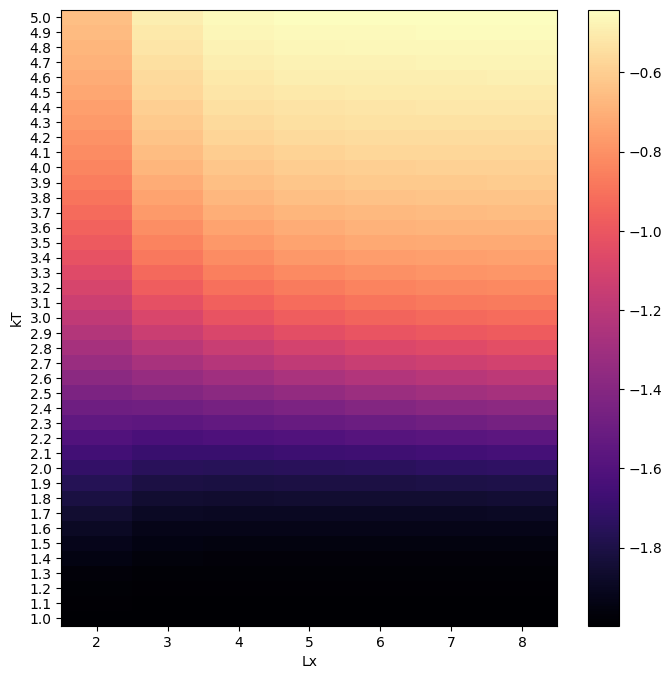

In [9]:
energy_array = np.load('energy.npy')
image(Lx, kT, energy_array)